In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

import time 
import numpy as np

import serial
import serial.tools.list_ports

import bokeh.plotting 
import bokeh.io 
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
HANDSHAKE = 0
VOLTAGE_REQUEST = 1
ON_REQUEST = 2
STREAM = 3
READ_DAQ_DELAY = 4

def find_arduino(port=None):
    """Get the name of the port that is connected to Arduino."""
    if port is None:
        ports = serial.tools.list_ports.comports()
        port = '/dev/cu.SLAB_USBtoUART'
    return port


def handshake_arduino(
    arduino, sleep_time=1, print_handshake_message=False, handshake_code=0
):
    """Make sure connection is established by sending
    and receiving bytes."""
    # Close and reopen
    arduino.close()
    arduino.open()

    # Chill out while everything gets set
    time.sleep(sleep_time)

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()
    time.sleep(sleep_time)

    # Send request to Arduino
    arduino.write(bytes([handshake_code]))
    #print(bytes([handshake_code]))

    # Read in what Arduino sent
    handshake_message = arduino.read_until()
    #print(handshake_message)

    # Send and receive request again
    arduino.write(bytes([handshake_code]))
    #time.sleep(sleep_time)
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout

def parse_raw(raw):
    """Parse bytes output from Arduino."""
    
    raw = raw.decode()
    
    if raw[-1] != "\n":
        print("Input must end with newline, otherwise message is incomplete.")
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )
        

    t, Pa = raw.rstrip().split(",")

    return int(t), float(Pa)

In [10]:
def daq_stream(arduino, n_data=100, delay=20):
    """Obtain `n_data` data points from an Arduino stream
    with a delay of `delay` milliseconds between each."""
    # Specify delay
    print(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())
    arduino.write(bytes([READ_DAQ_DELAY]) + (str(delay) + "x").encode())

    # Initialize output
    time_ms = np.empty(n_data)
    pressure = np.empty(n_data)

    # Turn on the stream
    arduino.write(bytes([STREAM]))

    # Receive data
    i = 0
    init_time = 0
    while i < n_data:
        raw = arduino.read_until()
        

        try:
            t, Pa = parse_raw(raw)
            if i == 0:
                init_time = t 
            if Pa > 80000:
                time_ms[i] = t - init_time
                pressure[i] = Pa
                i += 1
        except:
            print("Exception triggered")
            pass

    # Turn off the stream
    arduino.write(bytes([ON_REQUEST]))

    return pd.DataFrame({'time (ms)': time_ms, 'pressure (Pa)': pressure})

In [11]:
port = find_arduino()
arduino = serial.Serial(port, baudrate=115200)
arduino.setDTR(False)
arduino.setRTS(False)

In [31]:
handshake_arduino(arduino, handshake_code=HANDSHAKE, print_handshake_message=True)

Handshake message: Message received.



In [37]:

test_df = daq_stream(arduino, n_data=120, delay=150)

b'\x04150x'


In [38]:
test_df.to_csv('anastest4.csv', index=False)

### Load Expert Data into DataFrame
Preprocess to extract only breath information

In [14]:
#filepaths = ['bend3.csv', 'bend1.csv', 'bend2.csv']
filepaths = ['RohL_bend1.csv', 'RohL_rbend2.csv']
column_names = [
            "time (ms)", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "pressure (Pa)", "PSI", "atm"
        ]
for filepath in filepaths:
    expert_data_all = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    expert_data = expert_data_all[['time (ms)', 'pressure (Pa)']]
    threshold = 99000 # Pa
    drop_idxs = []
    remove_flag = False
    for i in range(len(expert_data)):
        if remove_flag and expert_data.iloc[i, 1] < threshold:
            break
        if expert_data.iloc[i, 1] > threshold:
            drop_idxs.append(i) # Pa is on column 1 
            remove_flag = True
    expert_data = expert_data.drop(drop_idxs)
    export_name = filepath.replace('.csv', '') + 'filtered.csv'
    expert_data.to_csv(export_name, index=False)
#expert_data['time (ms)'] = expert_data["time (ms)"] - expert_data['time (ms)'].iloc[0]

In [23]:
#filepaths = ['bend3.csv', 'bend1.csv', 'bend2.csv']
filepaths = ['RohL_rbend2filtered.csv', 'bend1filtered.csv', 'bend2filtered.csv', 'bend3filtered.csv']
column_names = [
            "time (ms)", "pressure (Pa)"
        ]

for filepath in filepaths:
    expert_data_all = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    expert_data = expert_data_all[['time (ms)', 'pressure (Pa)']]
    threshold = 99000 # Pa
    drop_idxs = []
    #remove_flag = False
    for i in range(len(expert_data)):
        if expert_data.iloc[i, 1] < threshold:
            drop_idxs.append(i) # Pa is on column 1 
        else:
            drop_idxs.pop()
            drop_idxs.pop()
            drop_idxs.pop()
            break
    expert_data = expert_data.drop(drop_idxs)
    #data["time (ms)"] = data["time (ms)"] - data["time (ms)"].iloc[0]
    expert_data['time (ms)'] = expert_data['time (ms)'] - expert_data['time (ms)'].iloc[0]
    drop_idxs = []
    for index, row in expert_data[::-1].iterrows():
        if row['pressure (Pa)'] < threshold:
            drop_idxs.append(index)
        else: 
            if len(drop_idxs) > 3:
                drop_idxs.pop()
                drop_idxs.pop()
                drop_idxs.pop()
            break
    print(drop_idxs)
    expert_data = expert_data.drop(drop_idxs)
    export_name = filepath.replace('filtered.csv', '') + 'dtwfiltered.csv'
    expert_data.to_csv(export_name, index=False)
#expert_data['time (ms)'] = expert_data["time (ms)"] - expert_data['time (ms)'].iloc[0]

[214, 213, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199, 198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170]
[175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159]
[166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148]
[161, 160, 159, 158, 157]


### Graph Expert & Trial Data

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

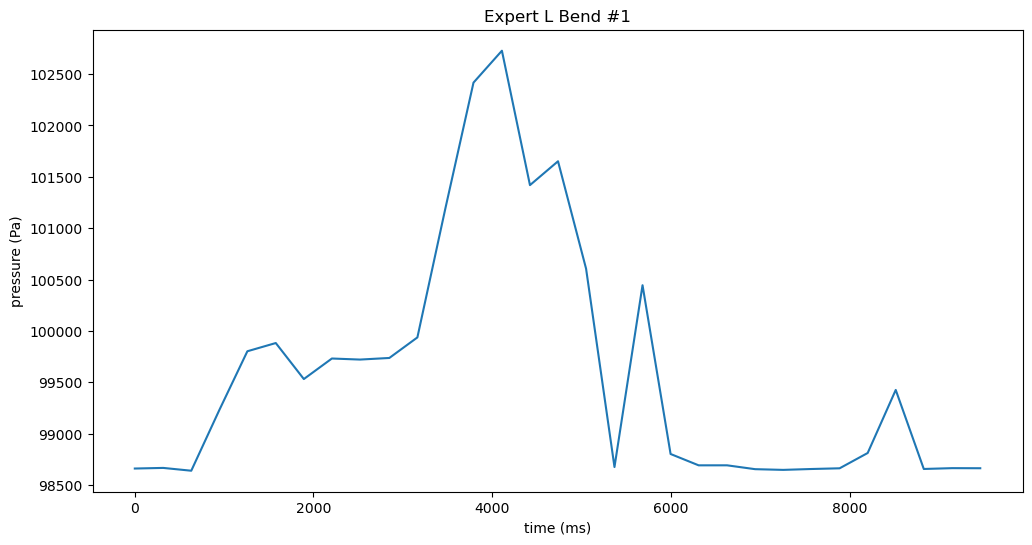

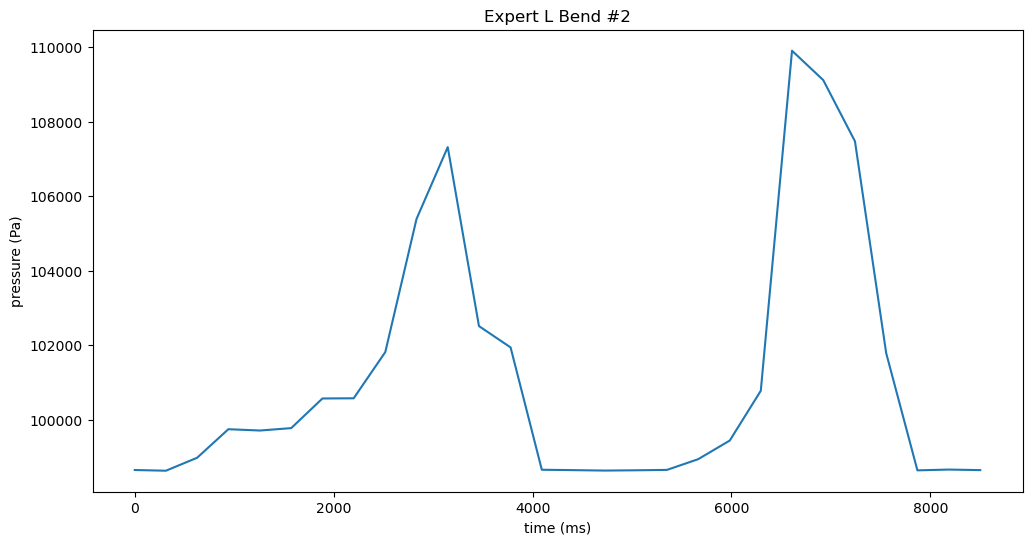

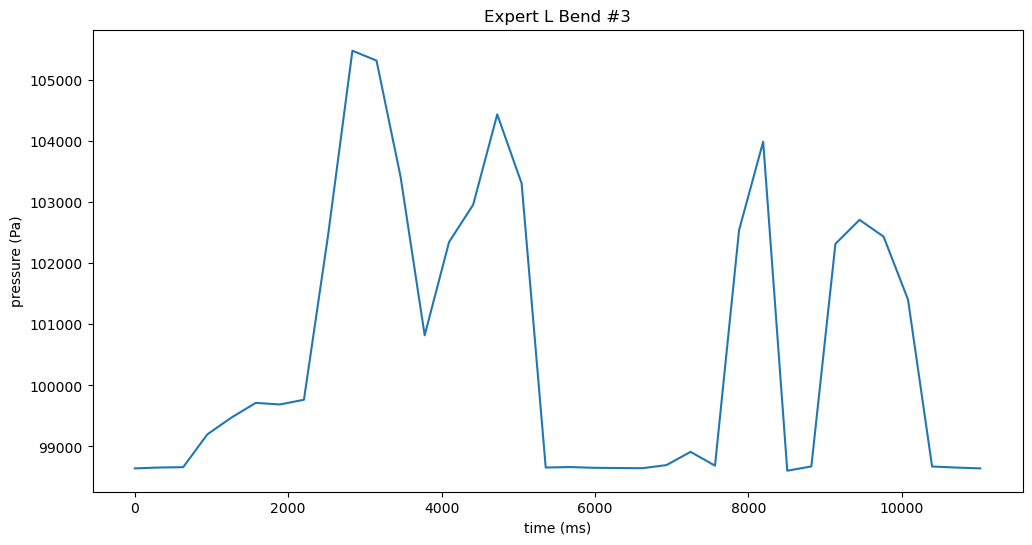

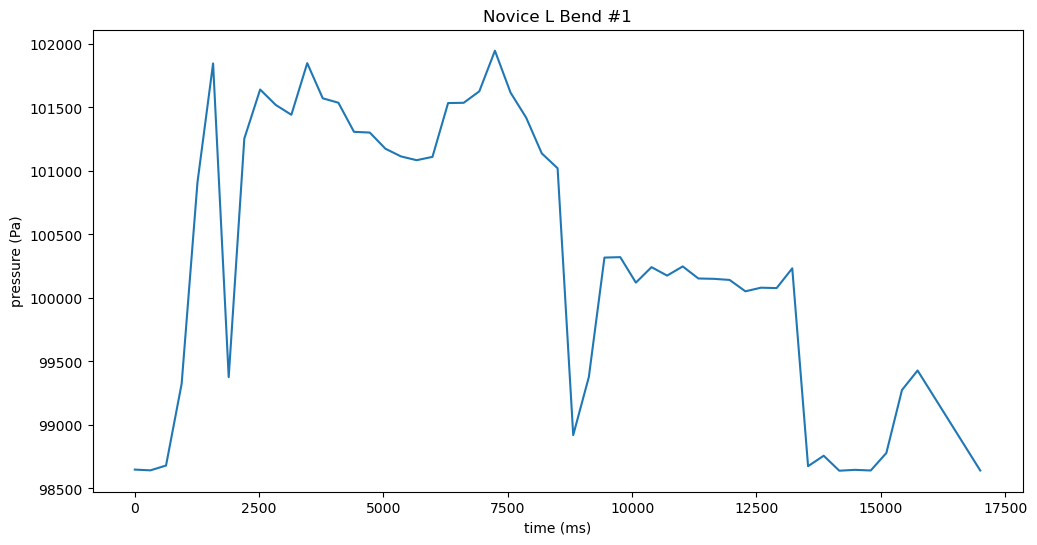

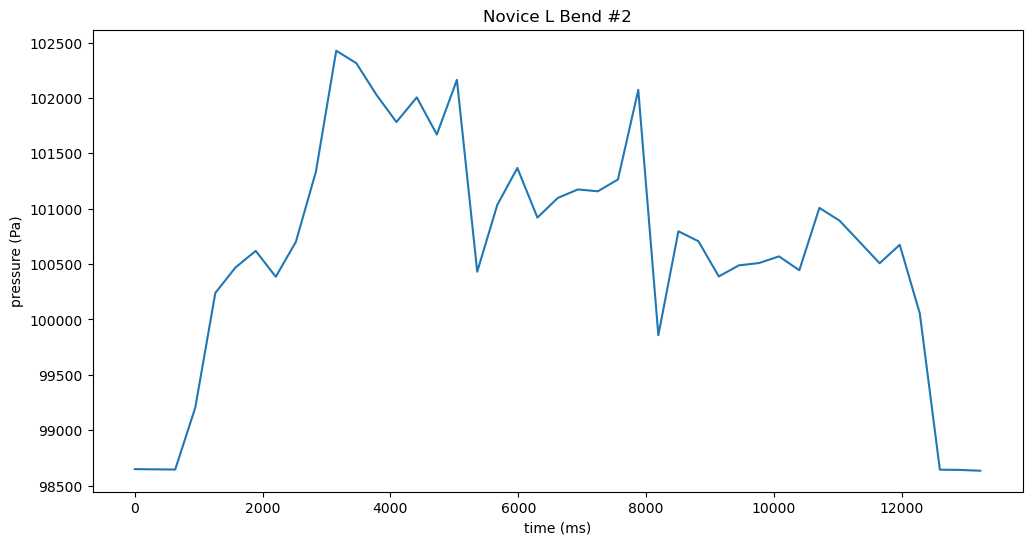

In [42]:
#size of the data plot
#sns.lineplot(data=test_df, x=test_df['time (ms)'], y=test_df['pressure (Pa)'])
plots = []
filepaths = ['bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
#filepaths = ['bend1filtered.csv', 'bend2filtered.csv', 'bend3filtered.csv']
count = 1
for filepath in filepaths:
    plt.figure(figsize=(12, 6))
    expert_data = pd.read_csv(filepath, names=column_names, skiprows=1)
    p = sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['pressure (Pa)'])
    p.set_title('Expert L Bend #' + str(count))
    plots.append(p)
    count+=1
rohfilepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv']

count = 1
for filepath in rohfilepaths:
    plt.figure(figsize=(12, 6))
    data = pd.read_csv(filepath, names=column_names, skiprows=1)
    p = sns.lineplot(data=data, x=data['time (ms)'], y=data['pressure (Pa)'])
    p.set_title('Novice L Bend #' + str(count))
    plots.append(p)
    count+=1


/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Expert L Bend #1')

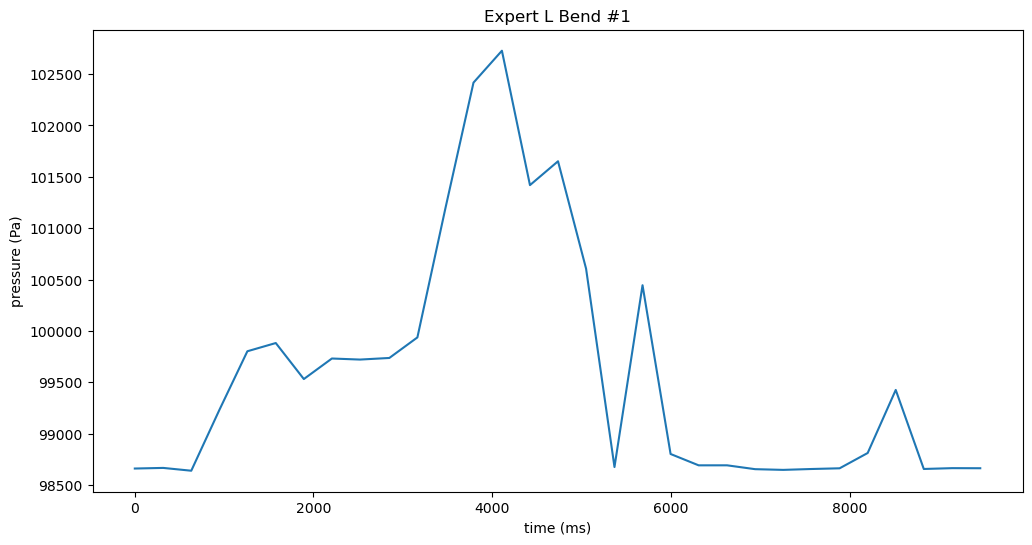

In [48]:
plt.figure(figsize=(12, 6))#size of the data plot
#sns.lineplot(data=test_df, x=test_df['time (ms)'], y=test_df['pressure (Pa)'])
expert_data = pd.read_csv('bend1dtwfiltered.csv', names=column_names, skiprows=1)
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['pressure (Pa)']).set_title('Expert L Bend #1')

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'dP: Expert L Bend #1')

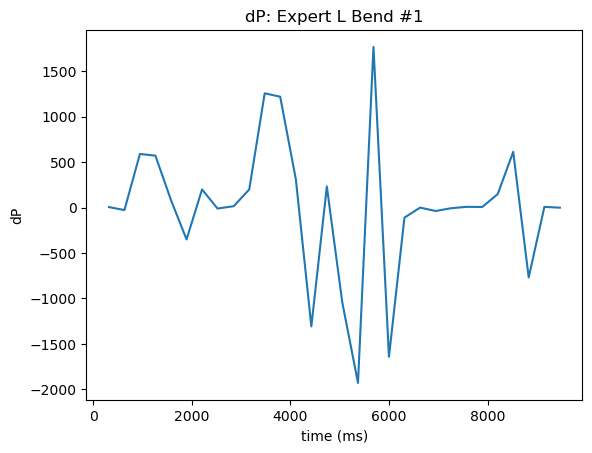

In [49]:
# expert_data["dt"] = 
expert_data["dt"] = expert_data["time (ms)"].diff()
expert_data["dP"] = expert_data["pressure (Pa)"].diff()

# expert_data
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['dP']).set_title('dP: Expert L Bend #1')
sns.lineplot(data=expert_data, x=expert_data['time (ms)'], y=expert_data['p']).set_title('dP: Expert L Bend #1')



### Feature extraction

[ 5  8 11 23 42 50]
{'min_Pa': 98639.41, 'max_Pa': 101946.28, 'num_peaks': 6, 'blow_duration': 16999, 'mean_pa': 100331.98807692308}
time (ms)          1574.00
pressure (Pa)    101846.19
Name: 5, dtype: float64


/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


AttributeError: 'Text' object has no attribute 'plot'

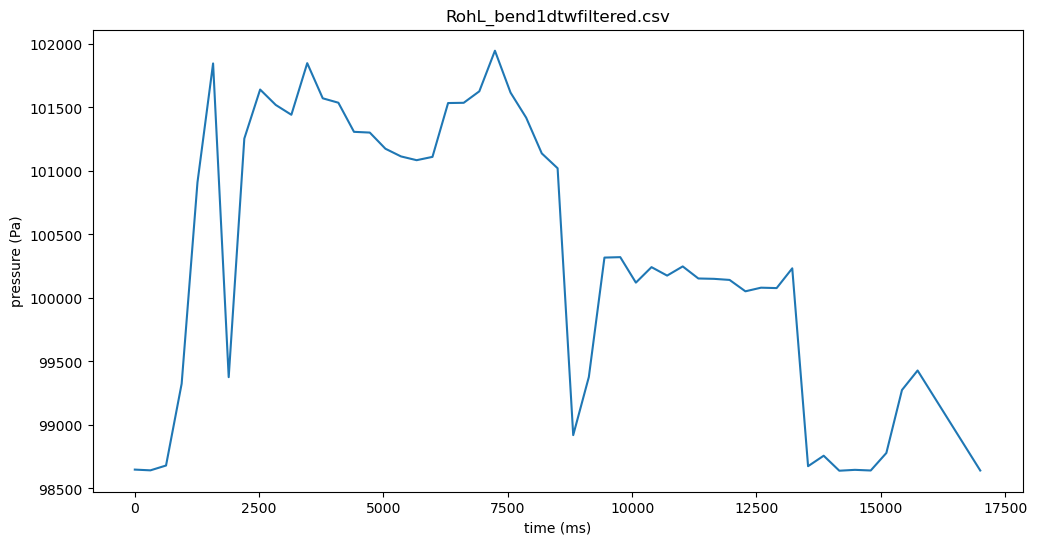

In [41]:
import pandas as pd
import os
from scipy.signal import find_peaks
def get_features(filepath):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'

    if not os.path.isfile(filepath):
        print(f"{filepath} not working.")

    # reads all the data into the data frame along with all the varaiables
    column_names = [
        "time (ms)","pressure (Pa)"
    ]
    data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    features = {
        'min_Pa': -1,
        'max_Pa': -1,
        'num_peaks': -1,
        'blow_duration': -1,
        'mean_pa': -1
    }
    features['blow_duration'] = data["time (ms)"].max()
    features['min_Pa'] = data['pressure (Pa)'].min()
    features['max_Pa'] = data['pressure (Pa)'].max()
    features['mean_pa'] = data['pressure (Pa)'].mean()
    peaks, _ = find_peaks(data['pressure (Pa)'].to_numpy(), threshold=100)
    print(peaks)
    
    features['num_peaks'] = len(peaks)
    print(features)
    plt.figure(figsize=(12, 6))
    p = sns.lineplot(data=data, x=data['time (ms)'], y=data['pressure (Pa)']).set_title(filepath)
    for peak in peaks:
        pt = data.iloc[peak]
        print(pt)
        p.plot(pt['time (ms)'], pt['pressure (Pa)'])
    #print(data)
    #will basically equalize the time
    #data["time (ms)"] = data["time (ms)"] - data["time (ms)"].iloc[0]
    return features

filepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv', 'bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
features = []
for filepath in filepaths:
    features.append(get_features(filepath))


### DTW analysis

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

RohL_bend1dtwfiltered.csv RohL_rbend2dtwfiltered.csv: 252.82242105263163
RohL_bend1dtwfiltered.csv bend1dtwfiltered.csv: 227.24662650602218
RohL_bend1dtwfiltered.csv bend2dtwfiltered.csv: 790.2295000000001
RohL_bend1dtwfiltered.csv bend3dtwfiltered.csv: 746.6444318181827
RohL_rbend2dtwfiltered.csv bend1dtwfiltered.csv: 283.1701351351345
RohL_rbend2dtwfiltered.csv bend2dtwfiltered.csv: 833.9967605633799
RohL_rbend2dtwfiltered.csv bend3dtwfiltered.csv: 791.5106329113936
bend1dtwfiltered.csv bend2dtwfiltered.csv: 760.9301694915265
bend1dtwfiltered.csv bend3dtwfiltered.csv: 594.6220895522387
bend2dtwfiltered.csv bend3dtwfiltered.csv: 748.3431249999996


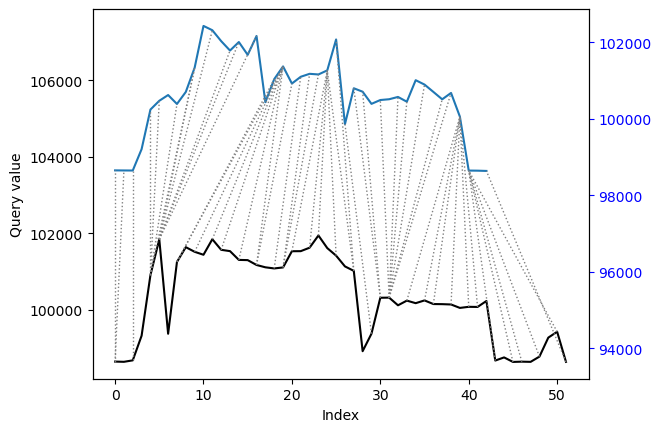

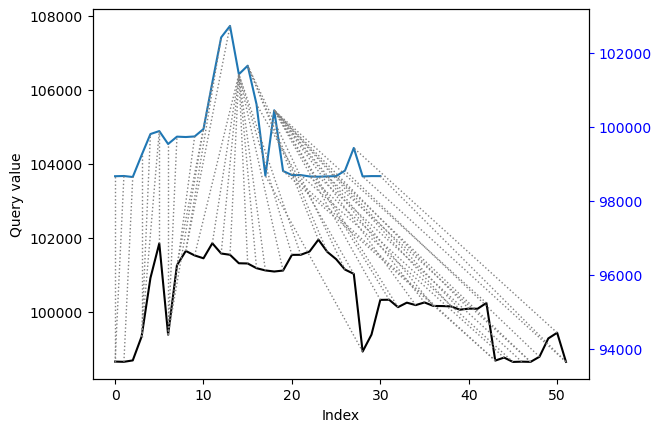

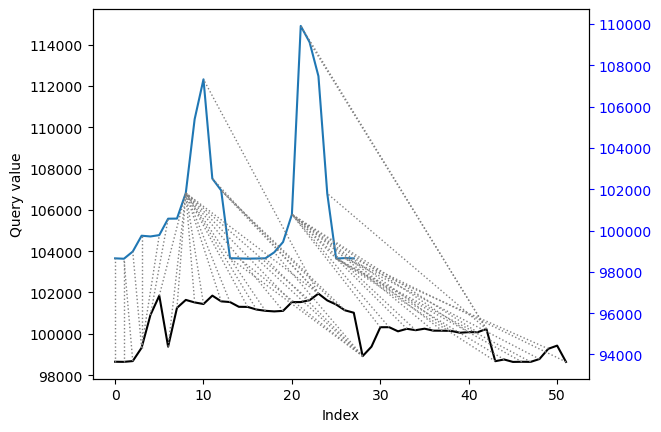

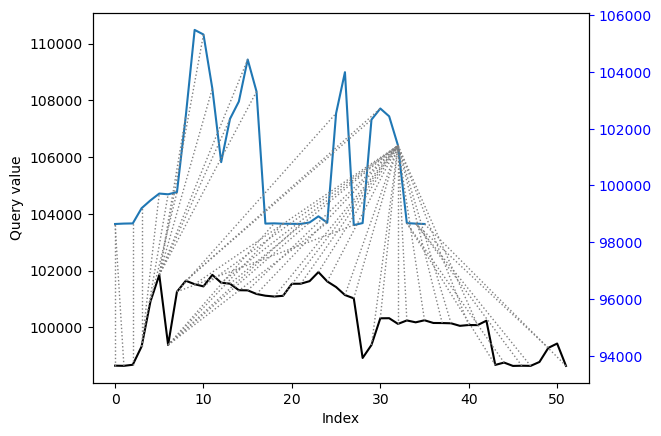

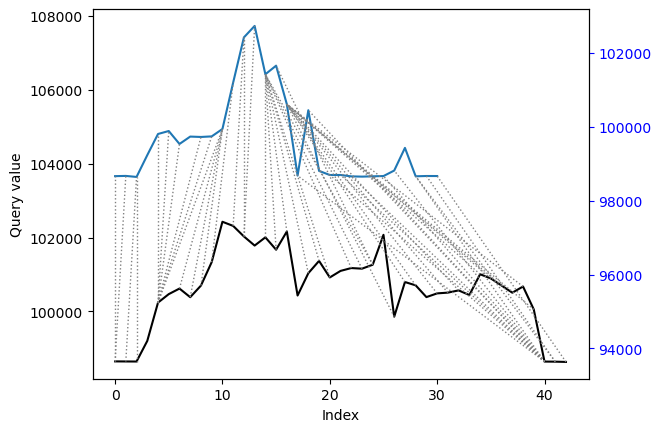

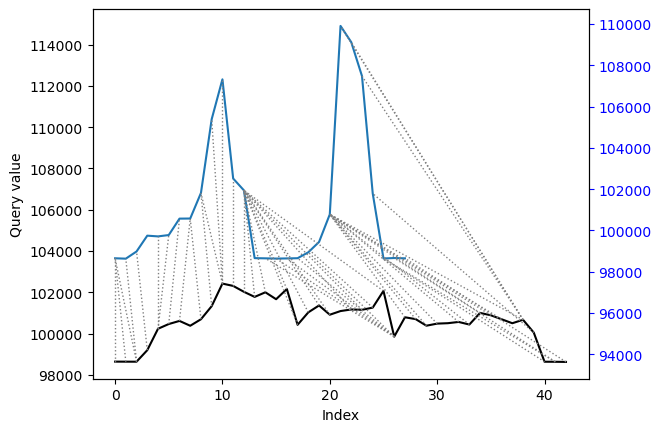

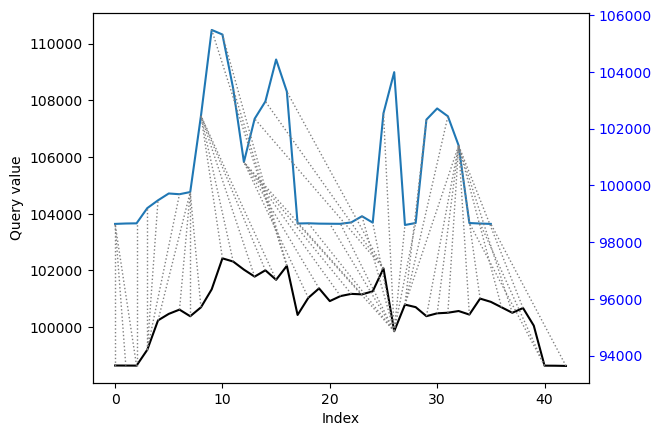

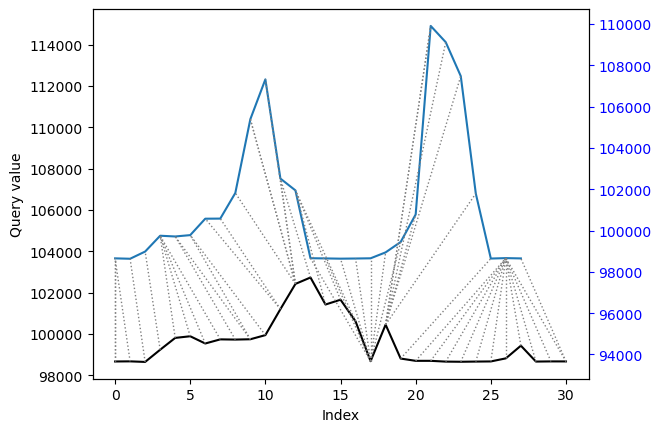

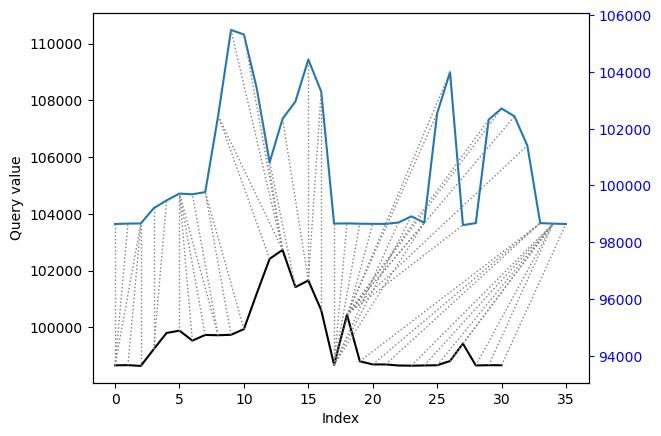

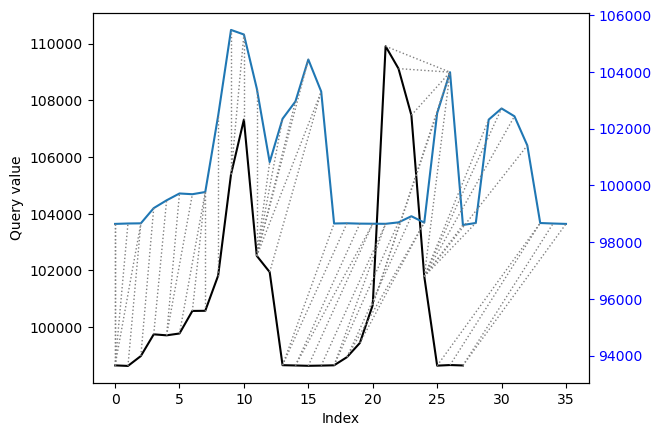

In [27]:
import pandas as pd
import os
from dtw import *

def load_data(filepath):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'

    if not os.path.isfile(filepath):
        print(f"{filepath} not working.")

    # reads all the data into the data frame along with all the varaiables
    column_names = [
        "time (ms)","pressure (Pa)"
    ]
    data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels
    #print(data)
    #will basically equalize the time
    #data["time (ms)"] = data["time (ms)"] - data["time (ms)"].iloc[0]
    return data["pressure (Pa)"].to_numpy()



# bend2 = load_data('bend2.csv')
# bend3 = load_data('bend3.csv')
# roh_bend = load_data('RohL_bend1.csv')
bends = []
filepaths = ['RohL_bend1dtwfiltered.csv', 'RohL_rbend2dtwfiltered.csv', 'bend1dtwfiltered.csv', 'bend2dtwfiltered.csv', 'bend3dtwfiltered.csv']
for filepath in filepaths:
    bends.append(load_data(filepath))
    #print(bends)

offsetamount = 5000
dtws = []
count = 1
for i in range(len(filepaths)):
    count = 0
    for j in bends[i+1:]:
        alignment = dtw(bends[i], j, keep_internals=True)
        print(filepaths[i], end=" ")
        print(filepaths[i+1:][count], end=": ")
        print(alignment.normalizedDistance)
        dtwPlotTwoWay(d=alignment, offset=offsetamount)
        dtws.append(dtw(bends[i], j, keep_internals=True))
        count+=1
        
# alignment = dtw(bends[0], bends[2], keep_internals=True)
# print(alignment.normalizedDistance)

#sns.lineplot()
# print(alignment3.normalizedDistance)
# alignment.plot(type="twoway")
# alignment2 = dtw(roh_bend, bend3, keep_internals=True, 
#     step_pattern=rabinerJuangStepPattern(6, "c"))
# alignment2.plot(type="twoway",offset=-2)
# print(alignment2.normalizedDistance)


## A noisy sine wave as query
# idx = np.linspace(0,6.28,num=100)
# #print(idx)
# query = np.sin(idx) + np.random.uniform(size=100)/10.0
# #print(query)

# ## A cosine is for template; sin and cos are offset by 25 samples
# template = np.cos(idx)
#print(template)

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

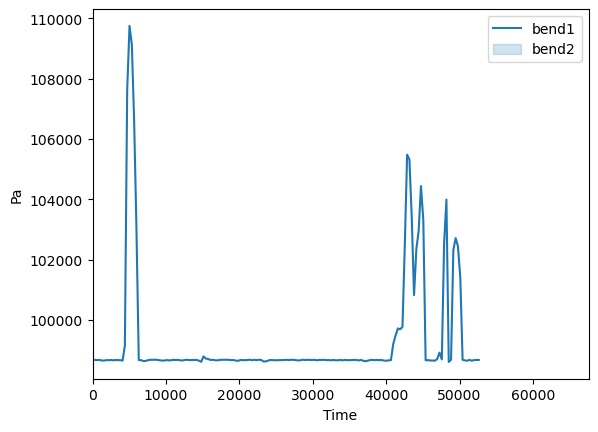

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


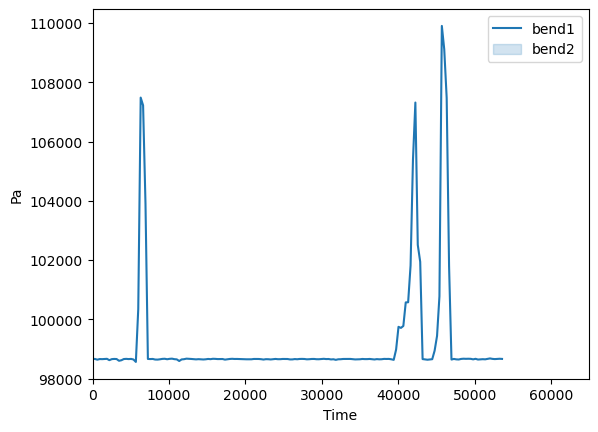

/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/be189/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


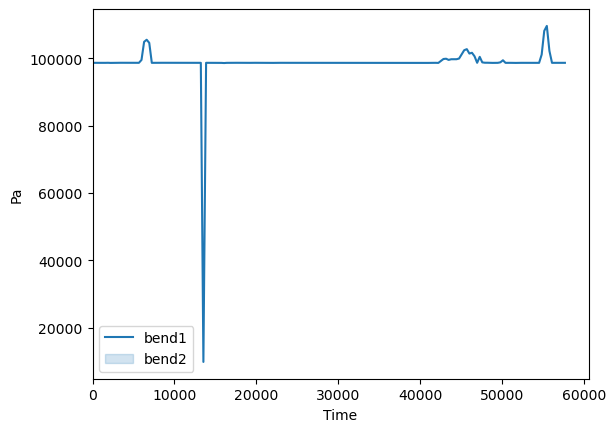

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

def read_and_plot(filepaths):
    #basepath = '/content/drive/MyDrive/The Hybrid Atelier/REU2024/1 - Project Folders/Rohita & Roy/2 - Data Collection/Collab Data Visualization/'
    plt.figure(figsize=(12, 6))#size of the data plot

    for filepath in filepaths:
        #filepath = basepath + filepath
        if not os.path.isfile(filepath):
            print(f"{filepath} not working.")
            continue

        # reads all the data into the data frame along with all the varaiables
        column_names = [
            "Time", "Acc_X", "Acc_Y", "Acc_Z","Gyr_X", "Gyr_Y", "Gyr_Z",
            "Mag_X", "Mag_Y", "Mag_Z","Temp", "Pa", "PSI", "atm"
        ]
        data = pd.read_csv(filepath, names=column_names, skiprows=1)#skip row just skips the labels

        #will basically equalize the time
        data["Time"] = data["Time"] - data["Time"].iloc[0]

        # will plot all the points
        # plt.plot(data["Time"], data["Pa"], label=os.path.basename(filepath))
        plt.figure("3 Bends")
        sns.lineplot(data=data, x=data["Time"], y=data["Pa"]).set(xlim=(0, None))
        plt.legend(['bend1', 'bend2', 'bend3'])
        plt.show()
    # plt.xlabel('Time')
    # plt.ylabel('Pressure (Pa)')
    # plt.title('Pressure over Time')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

if __name__ == "__main__":
    #filepaths = ["bt1.csv", "bt2.csv", "bt3.csv"]
    filepaths = ["bend3.csv", "bend2.csv", "bend1.csv"] #all the files i want in the graph
    read_and_plot(filepaths)